# Loads a JSON File and push it to NEO4J or memgraph database

needs database.json to read hexgrid, rooms and voronoi regions

In [2]:
import json
from tqdm import tqdm
from abc import ABC, abstractmethod
from neo4j import GraphDatabase
from py2neo import Graph

def batched(iterable, size):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]


class GraphImporter(ABC):
    @abstractmethod
    def execute(self, query: str, parameters: dict = None):
        ...

class MemgraphImporter(GraphImporter):
    def __init__(self):
        from gqlalchemy import Memgraph
        self.db = Memgraph()

    def execute(self, query: str, parameters: dict = None):
        self.db.execute(query, parameters=parameters or {})

class Neo4jImporter(GraphImporter):
    def __init__(self, uri="bolt://localhost:7687", user="neo4j", password="12345678"):
        from neo4j import GraphDatabase
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

        # Ensure py2neo graph object is initialized for visualization
        self.py2neo_graph = Graph(uri, auth=(user, password))

    def execute(self, query: str, parameters: dict = None):
        try:
            with self.driver.session() as session:
                session.run(query, parameters=parameters or {})
            return 1
        except Exception as e:
            print(f"❌ Cypher execution failed: {e}")
            return 0

def import_hexgrid(importer: GraphImporter, json_path, limit=None, batch_size=100, edge_batch_size=100):
    with open(json_path, 'r', encoding='utf-8') as f:
        hex_cells = json.load(f).get("hexGrid", [])

    if limit is not None:
        hex_cells = hex_cells[:limit]

    print(f"📦 Inserting {len(hex_cells)} HexCell nodes...")
    for batch in tqdm(list(batched(hex_cells, batch_size)), desc="HexCell node batches"):
        props = [
            {
                "rawIdx": c['rawIdx'], "row": c['row'], "col": c['col'],
                "x": round(c['x'], 2), "y": round(c['y'], 2),
                "free": c['free'], "potential": round(c['potential'], 2)
            }
            for c in batch
        ]
        query = (
            "UNWIND $cells AS cell "
            "CREATE (:HexCell {rawIdx: cell.rawIdx, row: cell.row, col: cell.col, "
            "x: cell.x, y: cell.y, free: cell.free, potential: cell.potential})"
        )
        importer.execute(query, parameters={"cells": props})

    print("🔗 Creating edges...")
    raw_idx_set = {cell["rawIdx"] for cell in hex_cells}
    edges = [{"a": cell["rawIdx"], "b": b} for cell in hex_cells for b in cell.get("neighbors", []) if b != -1 and b in raw_idx_set]

    for batch in tqdm(list(batched(edges, edge_batch_size)), desc="HexCell edge batches"):
        query = (
            "UNWIND $pairs AS pair "
            "MATCH (a:HexCell {rawIdx: pair.a}), (b:HexCell {rawIdx: pair.b}) "
            "CREATE (a)-[:CONNECTED_TO]->(b)"
        )
        importer.execute(query, parameters={"pairs": batch})

    print("✅ HexGrid import complete.")


def import_rooms(importer: GraphImporter, json_path, batch_size=100, edge_batch_size=100):
    with open(json_path, 'r', encoding='utf-8') as f:
        room_graph = json.load(f).get("roomGraph", [])

    print(f"📦 Inserting {len(room_graph)} Room nodes...")
    for batch in tqdm(list(batched(room_graph, batch_size)), desc="Room node batches"):
        props = [{"index": r["index"]} for r in batch]
        query = (
            "UNWIND $rooms AS room "
            "CREATE (:Room {index: room.index})"
        )
        importer.execute(query, parameters={"rooms": props})

    edges = []
    for room in room_graph:
        for neighbor in room.get("neighbors") or []:
            edges.append({"a": room["index"], "b": neighbor["index"], "distance": neighbor["distance"]})
        for cell_id in room.get("cellIndices") or []:
            edges.append({"a": room["index"], "cell": cell_id})

    neighbor_edges = [e for e in edges if "b" in e]
    cell_edges = [e for e in edges if "cell" in e]

    for batch in tqdm(list(batched(neighbor_edges, edge_batch_size)), desc="Room-Room edge batches"):
        query = (
            "UNWIND $pairs AS pair "
            "MATCH (a:Room {index: pair.a}), (b:Room {index: pair.b}) "
            "CREATE (a)-[:CONNECTED_TO {distance: pair.distance}]->(b)"
        )
        importer.execute(query, parameters={"pairs": batch})

    for batch in tqdm(list(batched(cell_edges, edge_batch_size)), desc="Room-Cell edge batches"):
        query = (
            "UNWIND $pairs AS pair "
            "MATCH (a:Room {index: pair.a}), (b:HexCell {rawIdx: pair.cell}) "
            "CREATE (a)-[:CONTAINS_CELL]->(b)"
        )
        importer.execute(query, parameters={"pairs": batch})

    print("✅ Room import complete.")


def import_voronoi(importer: GraphImporter, json_path, batch_size=100, edge_batch_size=100):
    with open(json_path, 'r', encoding='utf-8') as f:
        voronoi_map = json.load(f).get("voronoiMap", [])

    print(f"📦 Inserting {len(voronoi_map)} VoronoiRegion nodes...")
    for batch in tqdm(list(batched(voronoi_map, batch_size)), desc="Voronoi node batches"):
        props = [{"root": r["root"]} for r in batch]
        query = (
            "UNWIND $regions AS region "
            "CREATE (:VoronoiRegion {root: region.root})"
        )
        importer.execute(query, parameters={"regions": props})

    edges = []
    for region in voronoi_map:
        for node in region.get("nodes") or []:
            edges.append({
                "root": region["root"],
                "cell": node["rawIdx"],
                "hexDist": node["hexDist"],
                "centerDist": node["centerDist"]
            })

    for batch in tqdm(list(batched(edges, edge_batch_size)), desc="Voronoi edge batches"):
        query = (
            "UNWIND $pairs AS pair "
            "MATCH (a:VoronoiRegion {root: pair.root}), (b:HexCell {rawIdx: pair.cell}) "
            "CREATE (a)-[:HAS_NODE {hexDist: pair.hexDist, centerDist: pair.centerDist}]->(b)"
        )
        importer.execute(query, parameters={"pairs": batch})

    print("✅ Voronoi import complete.")


In [4]:
# Choose your database
use_neo4j = True
from py2neo import Graph
if use_neo4j:
    importer = Neo4jImporter(uri="bolt://localhost:7687", user="neo4j", password="12345678")
    indexes = [ 
        "CREATE INDEX hexcell_rawIdx_index IF NOT EXISTS FOR (n:HexCell) ON (n.rawIdx);",
        "CREATE INDEX room_index_index IF NOT EXISTS FOR (n:Room) ON (n.index);",
        "CREATE INDEX voronoi_root_index IF NOT EXISTS FOR (n:VoronoiRegion) ON (n.root);"
    ]
    
    for idx_query in indexes:
        importer.execute(idx_query)
else:
    importer = MemgraphImporter()

# Optional: clear graph
importer.execute("MATCH (n) DETACH DELETE n")


import time

# Start timer
start_time = time.time()

# Import steps
import_hexgrid(importer, "database.json", batch_size=2000, edge_batch_size=10000)
import_rooms(importer, "database.json", batch_size=200, edge_batch_size=10000)
import_voronoi(importer, "database.json", batch_size=500, edge_batch_size=10000)

# End timer
end_time = time.time()
total_duration = end_time - start_time

print(f"\n🕒 Total import time: {total_duration:.2f} seconds")


NameError: name 'Py2NeoGraph' is not defined

## Delete isolated Rooms

In [13]:
query = """
MATCH (r:Room)
WHERE size([x IN [(r)-[:CONNECTED_TO]-(other:Room) | other] | x]) < 3
WITH collect(r) AS isolatedRooms

UNWIND isolatedRooms AS r
MATCH (r)-[:CONTAINS_CELL]->(h:HexCell)
WITH isolatedRooms, collect(DISTINCT h) AS hexesToDelete

UNWIND hexesToDelete AS h
MATCH (v:VoronoiRegion)-[:HAS_NODE]->(h)
WITH isolatedRooms, hexesToDelete, collect(DISTINCT v) AS voronoiToDelete

FOREACH (r IN isolatedRooms | DETACH DELETE r)
FOREACH (h IN hexesToDelete | DETACH DELETE h)
FOREACH (v IN voronoiToDelete | DETACH DELETE v)
"""

print("✅ Success" if importer.execute(query) else "❌ Failure")

✅ Success


## See Rooms And Connections


MATCH (r1:Room)-[rel:CONNECTED_TO]->(r2:Room)  
RETURN r1, rel, r2


## Create a new Robot (delete all existing)

In [14]:
query = """
MATCH (r:Robot)
DETACH DELETE r
"""
print("✅ Success" if importer.execute(query) else "❌ Failure")

query = """
CREATE (:Robot {x: 712, y: 620})
"""

print("✅ Success" if importer.execute(query) else "❌ Failure")

✅ Success
✅ Success


## Connect Robot to closest HexCell and Room

In [15]:
query = """
// Step 1: Match Robot and delete all existing IS_AT edges (to HexCells and Rooms)
MATCH (r:Robot)
OPTIONAL MATCH (r)-[rel:IS_AT]->()
DELETE rel
WITH r

// Step 2: Find closest HexCell
WITH r, point({x: r.x, y: r.y}) AS robotPoint
MATCH (h:HexCell)
WITH r, h, robotPoint, point({x: h.x, y: h.y}) AS hexPoint
WITH r, h, point.distance(robotPoint, hexPoint) AS dist
ORDER BY dist ASC
LIMIT 1
WITH r, h

// Step 3: Find Room that contains this HexCell
OPTIONAL MATCH (room:Room)-[:CONTAINS_CELL]->(h)

// Step 4: Create IS_AT relationships to HexCell and its Room
CREATE (r)-[:IS_AT]->(h)
WITH r, room
WHERE room IS NOT NULL
CREATE (r)-[:IS_AT]->(room)
"""

print("✅ Success" if importer.execute(query) else "❌ Failure")

✅ Success


# Vizualization

## put the result of a query into a graph and store the graph in a JSON

In [76]:
import json
from neo4j import GraphDatabase
from neo4j.graph import Node, Relationship

def export_neo4j_to_visjson(uri, user, password, cypher_query, output_path="graph.json"):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    nodes_dict = {}
    edges = []

    with driver.session() as session:
        result = session.run(cypher_query)

        for record in result:
            for value in record.values():
                # Process nodes
                if isinstance(value, Node):
                    full_id = value.element_id
                    short_id = full_id.split(":")[-1]
                    label_group = list(value.labels)
                    group = label_group[0] if label_group else "Node"
                    label = f"{group}\n{short_id}"
                    title = f"{short_id}" 

                    nodes_dict[full_id] = {
                        "id": full_id,
                        "label": label,
                        "title": label,
                        "group": group
                    }

                # Process relationships
                elif isinstance(value, Relationship):
                    edges.append({
                        "from": value.start_node.element_id,
                        "to": value.end_node.element_id,
                        "label": value.type
                    })

    driver.close()

    graph_json = {
        "nodes": list(nodes_dict.values()),
        "edges": edges
    }

    with open(output_path, "w") as f:
        json.dump(graph_json, f, indent=2)

    print(f"✅ Graph exported to {output_path}")


## Show the Robot and its connection to the Rooms and HexCell

In [77]:
export_neo4j_to_visjson(
    uri="bolt://localhost:7687",
    user="neo4j",
    password="your_password",
    cypher_query="""
        // 1. Room connectivity
        MATCH (r1:Room)-[conn:CONNECTED_TO]->(r2:Room)
        RETURN r1 AS node1, r2 AS node2, conn AS rel
        
        UNION
        
        // 2. Robot -> HexCell
        MATCH (robot:Robot)-[rel1:IS_AT]->(hex:HexCell)
        WITH robot, hex, rel1
        RETURN robot AS node1, hex AS node2, rel1 AS rel
        
        UNION
        
        // 3. Robot -> Room
        MATCH (robot:Robot)-[rel2:IS_AT]->(room:Room)
        RETURN robot AS node1, room AS node2, rel2 AS rel
        
        UNION
        
        // 4. Room -> HexCell (only for that hex from robot)
        MATCH (robot:Robot)-[:IS_AT]->(hex:HexCell)<-[contains:CONTAINS_CELL]-(room:Room)
        RETURN room AS node1, hex AS node2, contains AS rel
            """,
    output_path="graph.json"
)

✅ Graph exported to graph.json


## Visualize the JSON via a html (interactive!)

In [83]:
import json
from pyvis.network import Network

with open("graph.json") as f:
    data = json.load(f)

net = Network(height="600px", width="100%", notebook=True, directed=True)

for node in data['nodes']:
    net.add_node(node['id'], label=node.get('label', str(node['id'])), group=node.get('group', 'default'))

for edge in data['edges']:
    net.add_edge(edge['from'], edge['to'], label=edge.get('label', ''))

net.show("graph_pyvis.html")


graph_pyvis.html


## make a screenshot of a headless browser loading the graph (too complicated)

In [84]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import os
import time

def capture_html_as_png(html_file, output_file="graph.png"):
    options = Options()
    options.add_argument('--headless=new')  # ✅ newer headless mode (Chrome 109+)
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--window-size=1200,800')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--log-level=3')  # Quiet logs

    # Optional: Use specific binary path (e.g., portable Chrome)
    # options.binary_location = "/path/to/chrome"

    driver = webdriver.Chrome(options=options)

    full_path = os.path.abspath(html_file)
    driver.get("file://" + full_path)

    time.sleep(2.5)  # Wait for vis.js to load graph

    driver.save_screenshot(output_file)
    driver.quit()

    print(f"✅ Screenshot saved to {output_file}")

# Example usage
capture_html_as_png("graph_pyvis.html")


✅ Screenshot saved to graph.png


## use the JSON create a graph in python and show it

✅ Graph PNG saved to graph_static.png


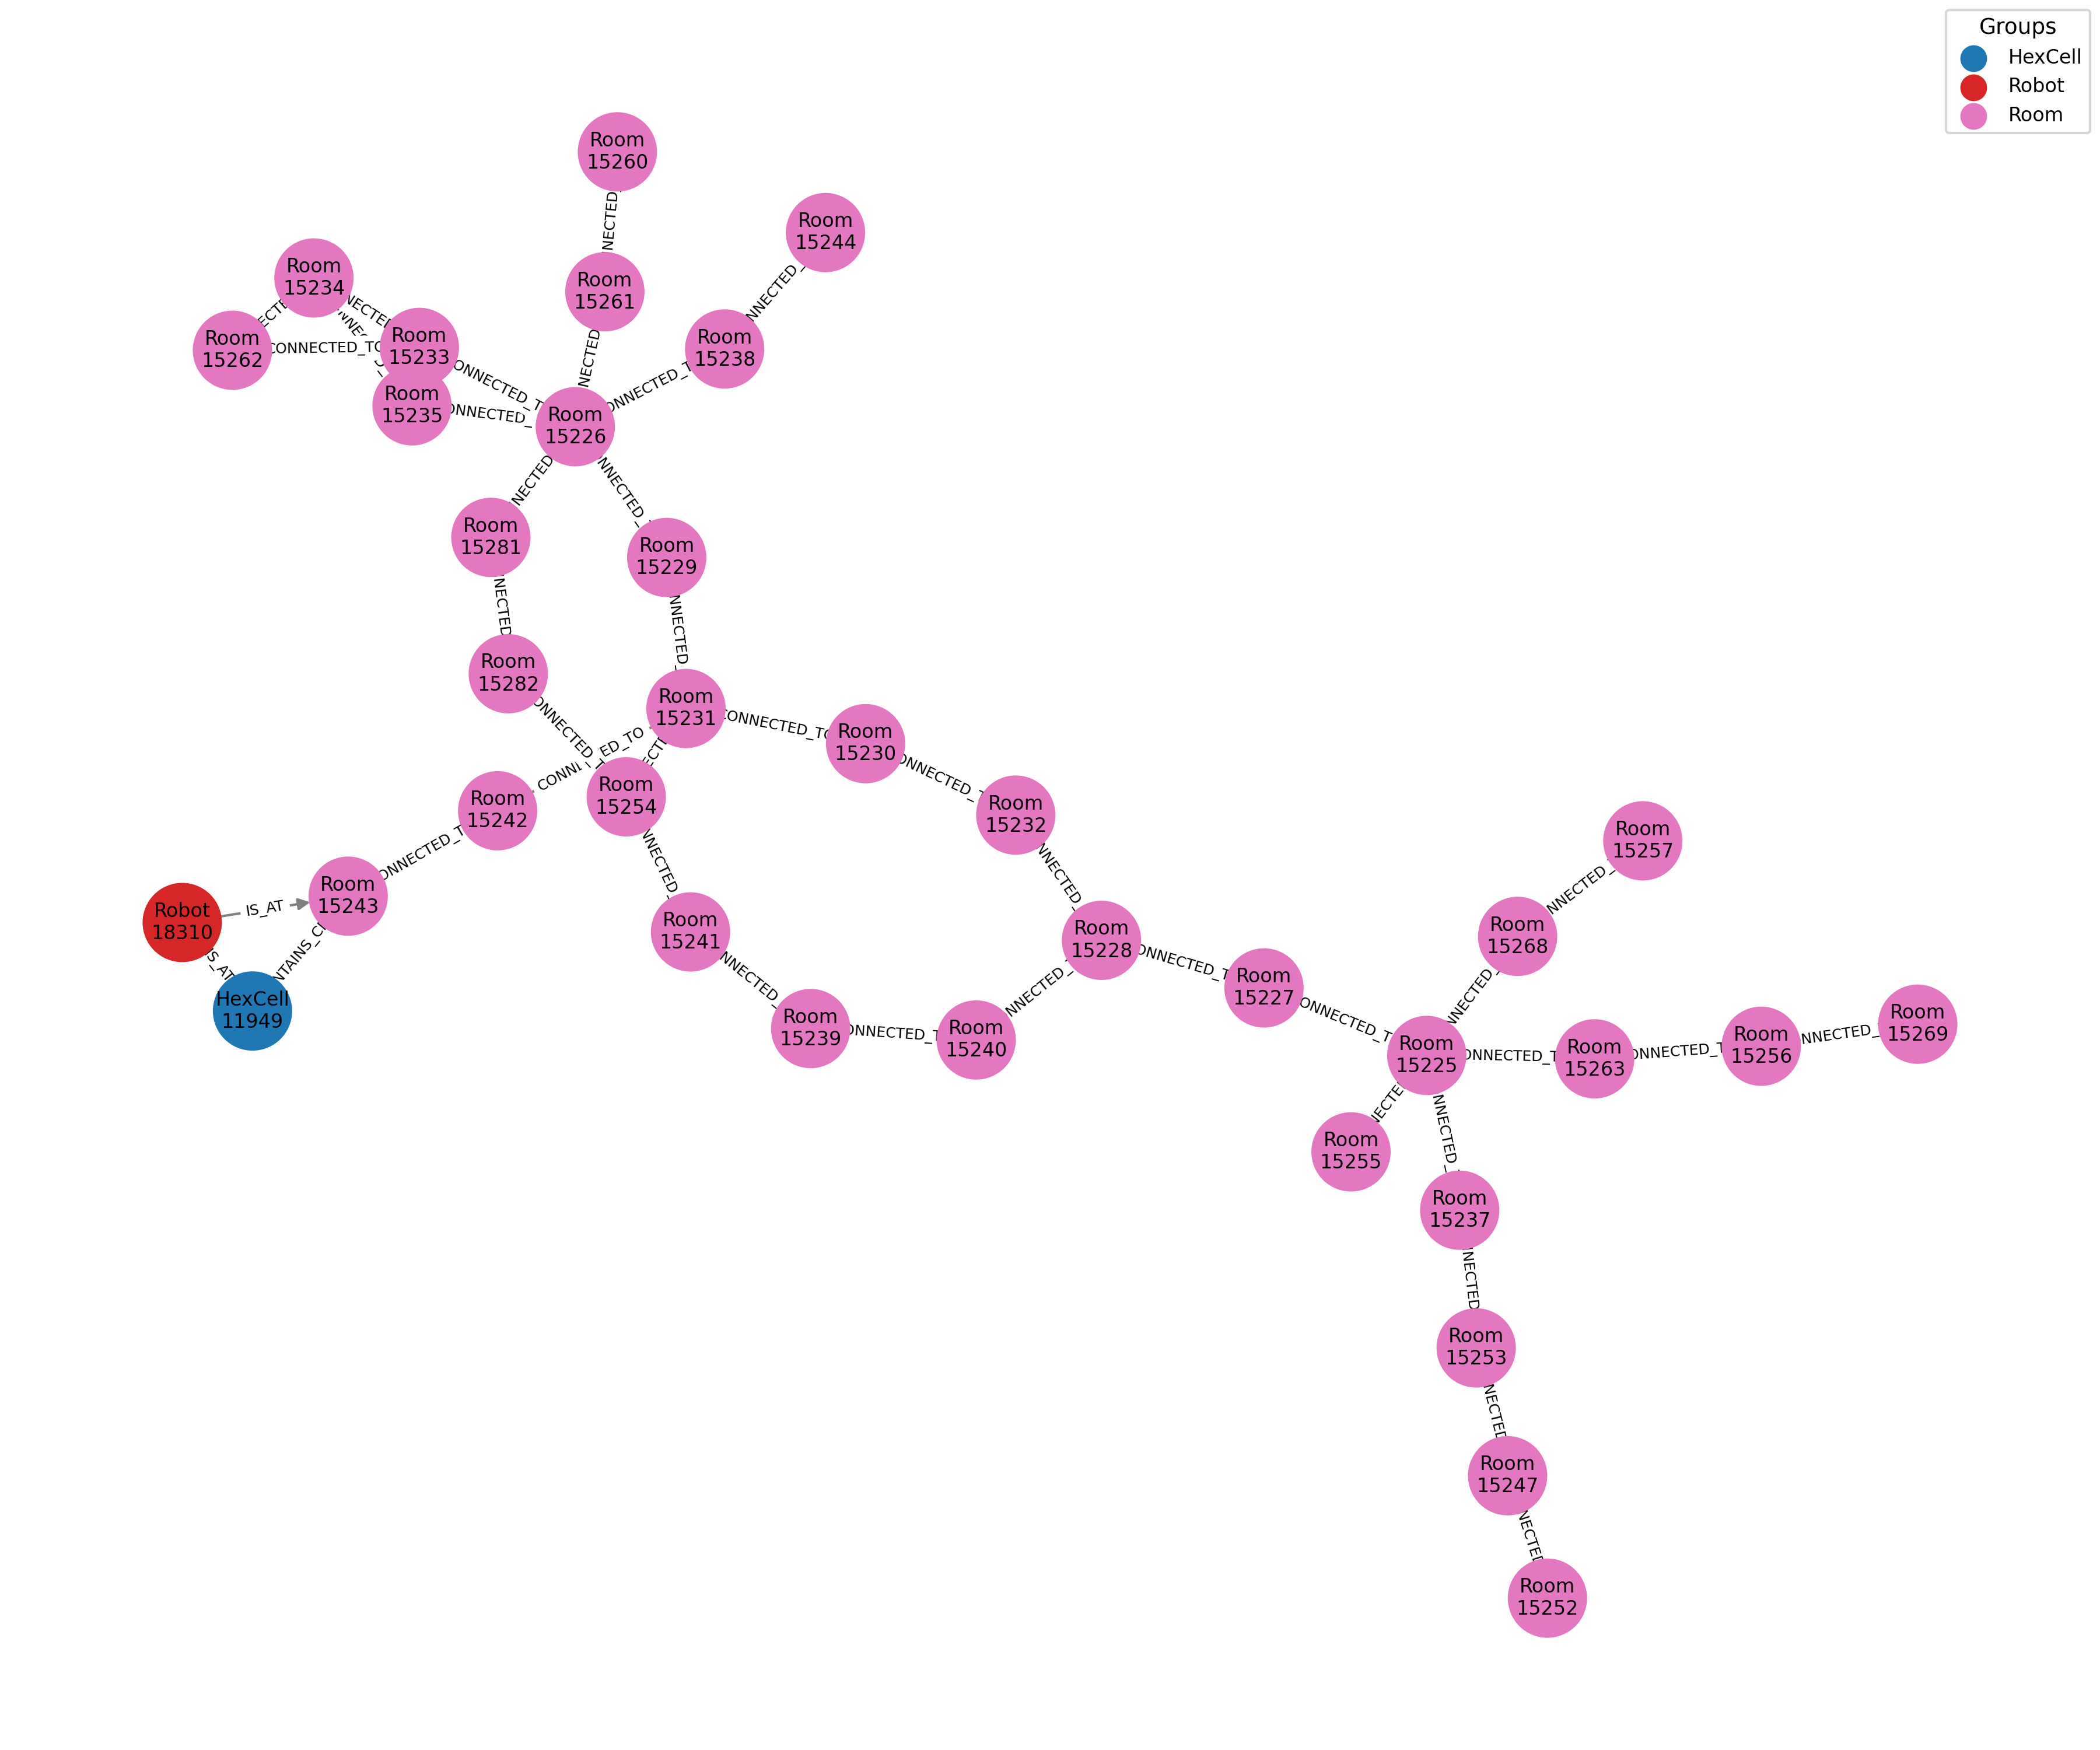

In [96]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps
from IPython.display import Image, display

def render_graph_from_json(json_path, output_png="graph_static.png"):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    G = nx.DiGraph()

    group_list = sorted(set(node.get('group', 'default') for node in data['nodes']))
    cmap = colormaps['tab10']
    group_to_color = {group: cmap(i / len(group_list)) for i, group in enumerate(group_list)}

    for node in data['nodes']:
        G.add_node(
            node['id'],
            label=node.get('label', str(node['id'])),
            group=node.get('group', 'default')
        )

    for edge in data['edges']:
        G.add_edge(edge['from'], edge['to'], label=edge.get('label', ''))

    # Layout and scale spacing
    pos = nx.kamada_kawai_layout(G)

    node_colors = [group_to_color[G.nodes[n]['group']] for n in G.nodes]
    node_labels = {n: G.nodes[n]['label'] for n in G.nodes}

    plt.figure(figsize=(12, 10))
    nx.draw(
        G, pos,
        labels=node_labels,
        node_size=1000,
        node_color=node_colors,
        edge_color='gray',
        font_size=8,
        font_weight='normal',
        linewidths=1,
        with_labels=True
    )

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    for group, color in group_to_color.items():
        plt.scatter([], [], c=[color], label=group, s=100)
    plt.legend(title="Groups", loc='upper right', fontsize=8, title_fontsize=9)

    plt.title("Graph Visualization", fontsize=12)
    plt.axis('off')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.savefig(output_png, dpi=300)
    plt.close()

    print(f"✅ Graph PNG saved to {output_png}")
    display(Image(filename=output_png))


# Example usage
render_graph_from_json("graph.json", "graph_static.png")
